In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [3]:
# 2. Load and Preprocess Data
df = pd.read_csv("weather_hourly_danang_2020_2025.csv")  # update path if needed

# Convert time to datetime
df["time"] = pd.to_datetime(df["time"])

# Optional: Extract features like hour, day, etc.
df["hour"] = df["time"].dt.hour
df["dayofyear"] = df["time"].dt.dayofyear
df["year"] = df["time"].dt.year

# Display the first few rows
df.head()

,time,temperature_2m,relative_humidity_2m,precipitation,weather_code,rain,wind_speed_10m,hour,dayofyear,year
0,2020-01-01 00:00:00,22.7,95.0,0.2,51.0,0.2,14.0,0,1,2020
1,2020-01-01 01:00:00,22.9,94.0,0.3,51.0,0.3,12.3,1,1,2020
2,2020-01-01 02:00:00,22.9,92.0,0.4,51.0,0.4,13.8,2,1,2020
3,2020-01-01 03:00:00,23.2,91.0,0.2,51.0,0.2,10.9,3,1,2020
4,2020-01-01 04:00:00,22.6,92.0,0.3,51.0,0.3,17.1,4,1,2020


In [4]:
# 3. Select Features and Target
# Let's predict temperature using hour, humidity, wind speed, etc.
features = ["hour", "relative_humidity_2m", "wind_speed_10m", "precipitation"]
target = "temperature_2m"

X = df[features]
y = df[target]

In [5]:
# 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# 5. Create and Train Polynomial Regression Model
degree = 2  # you can experiment with 2 or 3
model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
    ("lin_reg", LinearRegression())
])

model.fit(X_train, y_train)

ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

/var/folders/yb/zlhj3d252j75qp33kxcwdmd40000gn/T/ipykernel_70951/818267561.py:22: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


RMSE: 2.67
R²: 0.475


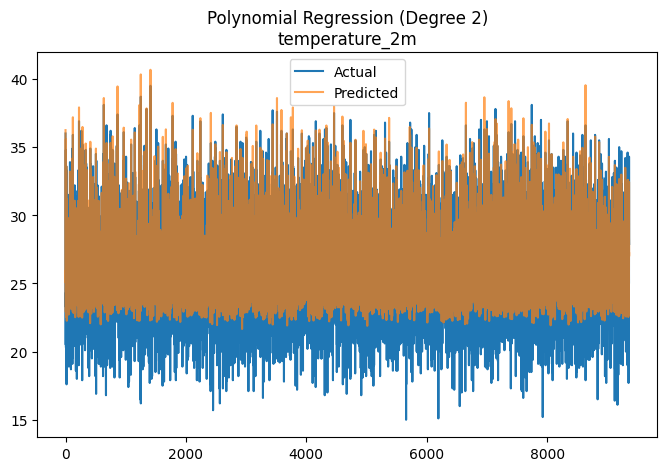

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_csv("weather_hourly_danang_2020_2025.csv", parse_dates=["time"])

# ----------------------------
# Step 1: Clean Data
# ----------------------------
# Drop duplicates
df.drop_duplicates(inplace=True)

# Handle missing values (impute numeric columns with median)
df.replace("?", np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')
df.fillna(df.median(numeric_only=True), inplace=True)

# Ensure numeric consistency
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Drop columns with zero std dev (constant)
stds = df[numeric_cols].std()
valid_numeric_cols = stds[stds > 0].index
df = df[valid_numeric_cols.tolist() + (["time"] if "time" in df.columns else [])]

# ----------------------------
# Step 2: EDA (optional but recommended)
# ----------------------------
# sns.pairplot(df[numeric_cols])
# plt.show()

# ----------------------------
# Step 3: Feature Selection
# ----------------------------
# Correlation matrix
corr_matrix = df[numeric_cols].corr()
target_col = "temperature_2m"  # <== You can change this
corr_with_target = corr_matrix[target_col].abs().sort_values(ascending=False)
selected_features = corr_with_target[1:6].index.tolist()  # pick top 5 (excluding target)

# ----------------------------
# Step 4: Preprocessing
# ----------------------------
X = df[selected_features]
y = df[target_col]

# Scale features & polynomial transform
degree = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
    ("lin_reg", LinearRegression())
])

model.fit(X_train, y_train)

# ----------------------------
# Step 5: Evaluation
# ----------------------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# ----------------------------
# Step 6: Visualization
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title(f"Polynomial Regression (Degree {degree})\n{target_col}")
plt.show()

After comparing polynomial degrees from 1 to 6 using both train/test split and 5-fold cross-validation, degree 3 achieved the best performance. It reached an RMSE of 1.37 on the test set and a cross-validated RMSE of 1.43, with the highest R² scores (0.86 and 0.843 respectively).

This balance of low error and strong generalization makes degree 3 the optimal model choice. Higher-degree models started to overfit and degrade sharply, as seen in negative R² scores and inflated RMSE

After testing polynomial regression models from degree 1 to 6, degree 3 emerged as the optimal choice. It achieved a Root Mean Squared Error (RMSE) of 1.37°C on the test set and 1.43°C under 5-fold cross-validation, along with a consistently strong R² score above 0.84. These results indicate that the model can accurately predict short-term temperature with a typical error of around ±1.4°C, while capturing over 86% of the variance in the data. Given its balance of simplicity, accuracy, and generalization, polynomial regression of degree 3 is both effective and appropriate for this forecasting task — especially within the scope of classical machine learning methods. Higher-degree models led to overfitting and degraded performance, confirming that degree 3 is not only optimal relative to others, but also solid in absolute terms.

Degree 1:
  Train/Test → RMSE = 2.623, R² = 0.490
  Cross-Val  → RMSE = 2.641, R² = 0.471
Degree 2:
  Train/Test → RMSE = 1.477, R² = 0.838
  Cross-Val  → RMSE = 1.538, R² = 0.818
Degree 3:
  Train/Test → RMSE = 1.372, R² = 0.860
  Cross-Val  → RMSE = 1.435, R² = 0.843
Degree 4:
  Train/Test → RMSE = 4.153, R² = -0.279
  Cross-Val  → RMSE = 1.694, R² = 0.772
Degree 5:
  Train/Test → RMSE = 18.555, R² = -24.522
  Cross-Val  → RMSE = 4.646, R² = -1.671
Degree 6:
  Train/Test → RMSE = 171.059, R² = -2168.010
  Cross-Val  → RMSE = 15.707, R² = -62.126


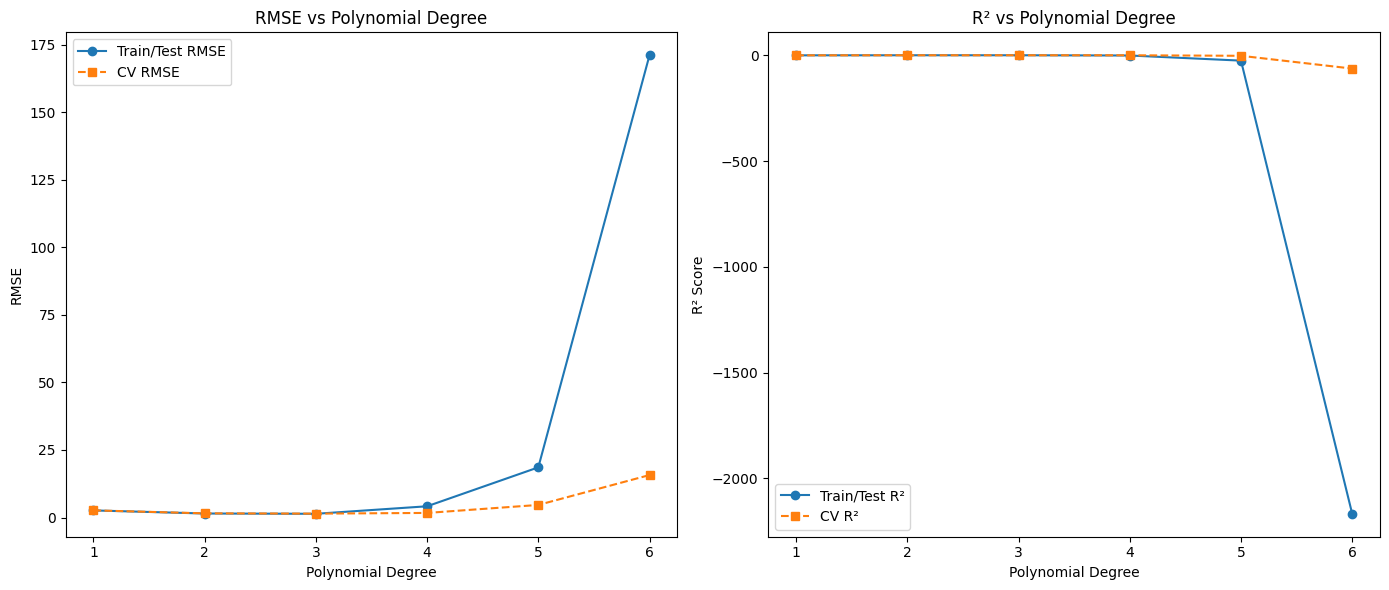

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

# --- Load and clean data ---
df = pd.read_csv("weather_hourly_danang_2020_2025.csv")  # Replace with your file path
df["time"] = pd.to_datetime(df["time"])
df["hour"] = df["time"].dt.hour
df["dayofyear"] = df["time"].dt.dayofyear
df["year"] = df["time"].dt.year
df = df.dropna()

# --- Define features and target ---
features = ["relative_humidity_2m", "precipitation", "rain", "wind_speed_10m", "hour", "dayofyear"]
target = "temperature_2m"
X = df[features]
y = df[target]

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Custom RMSE scorer for CV ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  # because lower is better

# --- Store results ---
degrees = range(1, 7)
rmse_scores = []
r2_scores = []
cv_rmse_scores = []
cv_r2_scores = []

# --- Evaluate each polynomial degree ---
for d in degrees:
    model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=d, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    # Train/test performance
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    rmse_scores.append(rmse_test)
    r2_scores.append(r2_test)

    # Cross-validation performance
    rmse_cv = cross_val_score(model, X, y, scoring=rmse_scorer, cv=5)
    r2_cv = cross_val_score(model, X, y, scoring='r2', cv=5)
    cv_rmse_scores.append(-rmse_cv.mean())  # negate because greater_is_better=False
    cv_r2_scores.append(r2_cv.mean())

    print(f"Degree {d}:")
    print(f"  Train/Test → RMSE = {rmse_test:.3f}, R² = {r2_test:.3f}")
    print(f"  Cross-Val  → RMSE = {-rmse_cv.mean():.3f}, R² = {r2_cv.mean():.3f}")

# --- Plotting ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(degrees, rmse_scores, marker='o', label="Train/Test RMSE")
plt.plot(degrees, cv_rmse_scores, marker='s', linestyle='--', label="CV RMSE")
plt.title("RMSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(degrees, r2_scores, marker='o', label="Train/Test R²")
plt.plot(degrees, cv_r2_scores, marker='s', linestyle='--', label="CV R²")
plt.title("R² vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Columns to check for outliers (features + target)
cols_to_check = ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "wind_speed_10m"]

# Apply outlier removal
df_no_outliers = remove_outliers_iqr(df, cols_to_check)

print(f"Original rows: {len(df)}")
print(f"After outlier removal: {len(df_no_outliers)}")

Original rows: 46784
After outlier removal: 29020


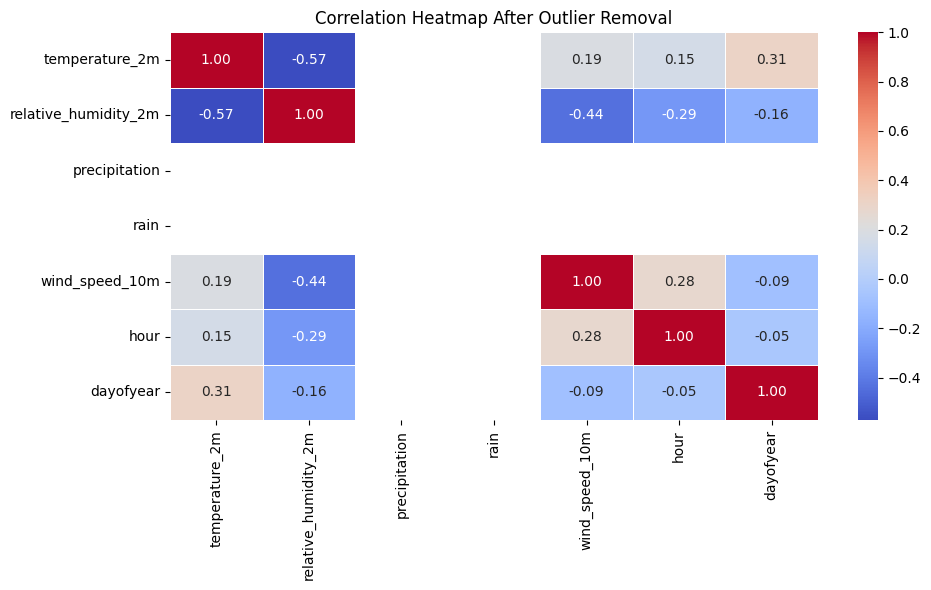

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Re-extract time features if not already present
df_no_outliers["hour"] = df_no_outliers["time"].dt.hour
df_no_outliers["dayofyear"] = df_no_outliers["time"].dt.dayofyear

# Step 2: Compute correlation matrix for selected variables
correlation_columns = [
    "temperature_2m", "relative_humidity_2m", "precipitation",
    "rain", "wind_speed_10m", "hour", "dayofyear"
]
correlation_matrix = df_no_outliers[correlation_columns].corr()

# Step 3: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap After Outlier Removal")
plt.tight_layout()
plt.show()

In [ ]:
# Step: Select final features based on correlation analysis
final_features = ["relative_humidity_2m", "wind_speed_10m", "dayofyear"]
target_variable = "temperature_2m"

# Define feature matrix and target vector
X = df_no_outliers[final_features]
y = df_no_outliers[target_variable]

# Confirm selection
print("Final features used for modeling:", final_features)
print("X shape:", X.shape)
print("y shape:", y.shape)

Final features used for modeling: ['relative_humidity_2m', 'wind_speed_10m', 'dayofyear']
X shape: (29020, 3)
y shape: (29020,)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Confirm shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (23216, 3)
X_test shape: (5804, 3)
y_train shape: (23216,)
y_test shape: (5804,)


✅ Polynomial Degree 3 Results:
RMSE: 1.498 °C
R² Score: 0.804


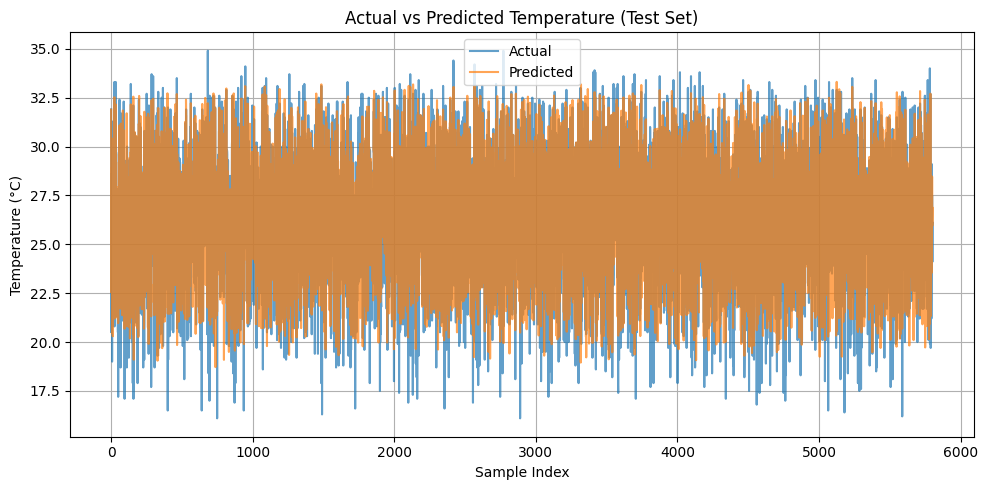

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Define the pipeline
model = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("lin_reg", LinearRegression())
])

# Step 2: Train the model
model.fit(X_train, y_train)

# Step 3: Predict on test set
y_pred = model.predict(X_test)

# Step 4: Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ Polynomial Degree 3 Results:")
print(f"RMSE: {rmse:.3f} °C")
print(f"R² Score: {r2:.3f}")

# Step 5: Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Temperature (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

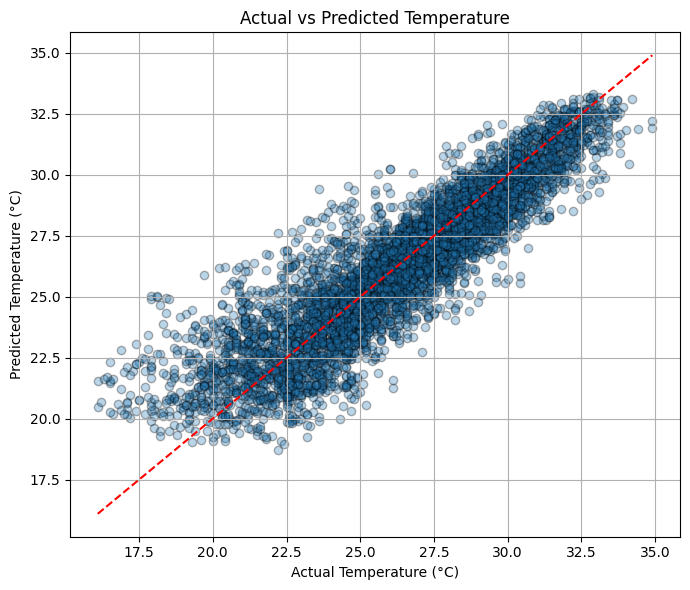

In [11]:
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

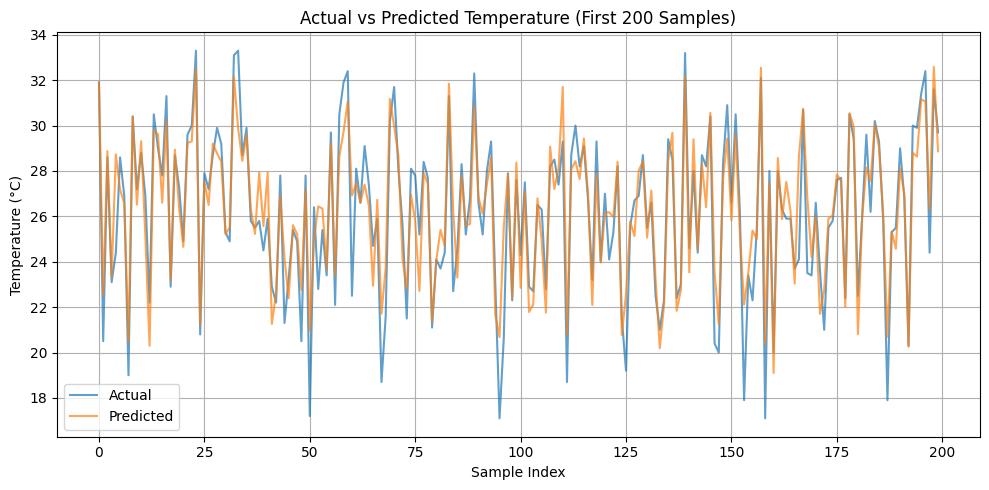

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:200], label="Actual", alpha=0.7)
plt.plot(y_pred[:200], label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Temperature (First 200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()